In [1]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt
import csv, io
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
#conf = SparkConf().set("spark.jars", "/home/cloudera/Downloads/spark-csv_2.10-1.5.0.jar").setAppName('Group10_YelpDataset')
conf = SparkConf().setAppName('Group10_YelpDataset_V1.0')
sqlContext = SQLContext(sc)
sc
from pyspark.ml.regression import LinearRegression

In [2]:
path = "/home/cloudera/yelp_academic_dataset_business.json"

In [4]:
businessJson = sqlContext.read.json(path)
businessJson.registerTempTable("businessTable")
cityPhoenix = sqlContext.sql("SELECT * FROM businessTable where city in ('Phx', 'Phoenix Valley', 'Pheonix', 'Pheonix AZ', 'Phoenix' ) and categories like '%Restaurant%'")
cityPhoenix.registerTempTable("phoenixTable")

In [9]:
#cityPhoenix.toPandas().to_csv("/home/cloudera/trial.csv", encoding='utf-8')

In [4]:
# Load training data
#training = sqlContext.read.format("libsvm")\
    #.load("/home/cloudera/trial.csv")

In [5]:

cityPhoenix.show(5)

+----------------+--------------------+--------------------+--------------------+-------+--------------------+-------+-------------+--------------+--------------------+------------+-----------+------------+-----+-----+
|         address|          attributes|         business_id|          categories|   city|               hours|is_open|     latitude|     longitude|                name|neighborhood|postal_code|review_count|stars|state|
+----------------+--------------------+--------------------+--------------------+-------+--------------------+-------+-------------+--------------+--------------------+------------+-----------+------------+-----+-----+
| 2801 N 15th Ave|[null,null,full_b...|_c3ixq9jYKxhLUB0c...|Bars, Sports Bars...|Phoenix|[11:0-23:0,11:0-2...|      1|   33.4798071|  -112.0911877|Original Hamburge...|            |      85007|         277|  4.0|   AZ|
| 4131 N 83rd Ave|[null,null,null,{...|3ByGQOVgds2YEu6kz...|Nightlife, Bars, ...|Phoenix|                null|      1|   33.

Displaying the schema of the current data set after refining

In [80]:
cityPhoenix.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the number of rows in the dataset

In [81]:
cityPhoenix.count()

3844

In [82]:
cityPhoenix.crosstab('state','stars').show()

+-----------+---+---+---+---+---+---+---+---+---+
|state_stars|5.0|3.0|2.5|1.5|4.0|3.5|2.0|4.5|1.0|
+-----------+---+---+---+---+---+---+---+---+---+
|         AZ|125|652|389| 98|937|846|246|493| 31|
|         OR|  3|  0|  2|  0|  6|  6|  0| 10|  0|
+-----------+---+---+---+---+---+---+---+---+---+



# Pre -Processing Data - get data ready for modelling

Creation of data for modelling (numeric columns) 
Independent variable - longitude, latitude, review_count
Dependent variable -stars
Goal: The variance of the stars with the change in latitude, longitude and review_count variables.

In [5]:
ModelData = sqlContext.sql("Select stars,longitude, latitude, review_count from phoenixTable")
ModelData.show(5)

+-----+--------------+-------------+------------+
|stars|     longitude|     latitude|review_count|
+-----+--------------+-------------+------------+
|  4.0|  -112.0911877|   33.4798071|         277|
|  2.5|  -112.2360764|   33.4952976|           3|
|  2.5|  -112.2251729|   33.4796712|          14|
|  2.0|-112.235797843|33.4954215852|           4|
|  3.5|  -112.0877381|   33.6397742|         230|
+-----+--------------+-------------+------------+
only showing top 5 rows



In [56]:
ModelData

DataFrame[stars: double, longitude: double, latitude: double, review_count: bigint]

In [7]:
ModelData.toPandas().head()

,stars,longitude,latitude,review_count
0,4.0,-112.091188,33.479807,277
1,2.5,-112.236076,33.495298,3
2,2.5,-112.225173,33.479671,14
3,2.0,-112.235798,33.495422,4
4,3.5,-112.087738,33.639774,230


In [9]:
ModelData.describe(['stars','longitude', 'latitude', 'review_count']).show()

+-------+------------------+-------------------+------------------+-----------------+
|summary|             stars|          longitude|          latitude|     review_count|
+-------+------------------+-------------------+------------------+-----------------+
|  count|              3844|               3844|              3844|             3844|
|   mean|3.4497918834547345|-112.13958356779634| 33.56210648820647|97.89542143600416|
| stddev| 0.839687679399409| 0.9005390729195051|1.3097495118370295|178.8233727360186|
|    min|               1.0|     -122.831588876|         -33.50857|                3|
|    max|               5.0|        -111.790112|     42.2959631079|             2267|
+-------+------------------+-------------------+------------------+-----------------+



# Pre Analysis -Before Modelling

Initial preparations for the creating a model. 
Modelling: Linear regression model.
Input needed: Labelled point 

Pre Analaysis: 
1) Perform the correlation between the variables to be modelled
2) Check for the distribution of the data - box plot and scatter plot
3) Histogram to check for the distribution of data

In [6]:
import pyspark.mllib
import pyspark.mllib.regression
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import * 

In [7]:
temp = ModelData.map(lambda line: LabeledPoint(line[0],[line[1:]]))

In [8]:
temp.take(5)

[LabeledPoint(4.0, [-112.0911877,33.4798071,277.0]),
 LabeledPoint(2.5, [-112.2360764,33.4952976,3.0]),
 LabeledPoint(2.5, [-112.2251729,33.4796712,14.0]),
 LabeledPoint(2.0, [-112.235797843,33.4954215852,4.0]),
 LabeledPoint(3.5, [-112.0877381,33.6397742,230.0])]

In [9]:
temp

PythonRDD[18] at RDD at PythonRDD.scala:43

In [10]:
from pyspark.mllib.util import MLUtils
from pyspark.mllib.linalg import Vectors, Matrices
from pyspark.mllib.feature import StandardScaler

Perform statistical operations on the data to be modelled

In [125]:
features = ModelData.map(lambda row: row[1:])
Correlationfeature = ModelData.map(lambda row: row[0:])

In [126]:
features.take(1)

[(-112.0911877, 33.4798071, 277)]

The below code snippet calculates the mean and variance of the vectors. The output shows the distribution of the data and the number of zeros in the data, we see that there are no zeros in the data.

In [127]:
from pyspark.mllib.stat import Statistics

summary = Statistics.colStats(Correlationfeature)
print(summary.mean())
print(summary.variance())
print(summary.numNonzeros())

[   3.44979188 -112.13958357   33.56210649   97.89542144]
[  7.05258869e-01   8.11181647e-01   1.71589017e+00   3.19861197e+04]
[ 3844.  3844.  3844.  3844.]


Checking for correlation of the columns to be able to run a regression model. Now that the plot gives an output that the independent variables are not correlated

In [86]:
data =features # an RDD of Vectors
# calculate the correlation matrix using Pearson's method. Use "spearman" for Spearman's method.
# If a method is not specified, Pearson's method will be used by default. 
print(Statistics.corr(data, method="pearson"))

[[ 1.         -0.05656771  0.04078885  0.24016736]
 [-0.05656771  1.         -0.55917718  0.04100118]
 [ 0.04078885 -0.55917718  1.         -0.01492386]
 [ 0.24016736  0.04100118 -0.01492386  1.        ]]


Convert the RDD of data into lists and arrays to be able to plot the variables to be able to understand the distribution of data

In [46]:
result = sqlContext.sql("Select review_count from phoenixTable")
result_array = result.rdd.map(lambda row: row.review_count).sample(False,0.1).collect()
result_array

[116,
 127,
 11,
 16,
 29,
 45,
 87,
 207,
 239,
 47,
 16,
 7,
 19,
 22,
 166,
 10,
 86,
 98,
 45,
 88,
 51,
 31,
 23,
 66,
 5,
 21,
 34,
 5,
 10,
 94,
 84,
 27,
 4,
 40,
 59,
 531,
 19,
 5,
 14,
 32,
 143,
 3,
 14,
 44,
 105,
 287,
 13,
 27,
 70,
 38,
 131,
 4,
 8,
 265,
 14,
 50,
 28,
 221,
 50,
 19,
 25,
 90,
 10,
 10,
 31,
 3,
 112,
 177,
 49,
 65,
 86,
 98,
 103,
 9,
 19,
 12,
 130,
 64,
 318,
 68,
 98,
 55,
 15,
 8,
 3,
 135,
 75,
 39,
 3,
 59,
 24,
 18,
 113,
 5,
 12,
 4,
 113,
 10,
 30,
 23,
 88,
 31,
 12,
 208,
 36,
 8,
 16,
 36,
 3,
 35,
 10,
 4,
 6,
 129,
 102,
 6,
 44,
 62,
 33,
 54,
 25,
 371,
 113,
 113,
 228,
 11,
 481,
 6,
 4,
 12,
 74,
 120,
 131,
 131,
 21,
 116,
 3,
 22,
 17,
 191,
 13,
 879,
 3,
 149,
 87,
 30,
 61,
 8,
 104,
 11,
 23,
 33,
 77,
 30,
 11,
 7,
 22,
 220,
 20,
 5,
 20,
 62,
 11,
 16,
 8,
 10,
 26,
 13,
 149,
 9,
 66,
 5,
 161,
 10,
 186,
 42,
 488,
 597,
 13,
 4,
 130,
 144,
 55,
 58,
 9,
 9,
 71,
 7,
 27,
 740,
 31,
 7,
 10,
 199,
 14,
 36,
 18,
 15,

In [57]:
result

DataFrame[review_count: bigint]

Plot a BoxPlot on review_count column to see if any outliers exist. From the plot, we find that they are pretty many outliers.

In [42]:
%matplotlib inline

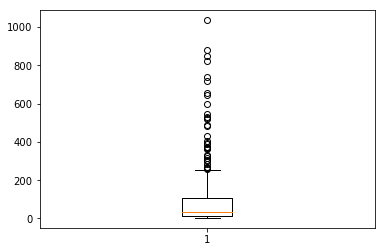

In [76]:
import matplotlib.pyplot as plt

plt.boxplot(result_array)
plt.show()

Converting data in a DataFrame into a list to run the necessary plots

In [61]:
datatoModel = ModelData
data_array =datatoModel.rdd.sample(False,0.1).map(lambda row: (row.stars, row.longitude,row.latitude,row.review_count))
data_array_stars = data_array.map(lambda (stars, longitude, latitude, review_count): stars ).collect()
data_array_longitude = data_array.map(lambda (stars, longitude, latitude, review_count): longitude ).collect()
data_array_latitude = data_array.map(lambda (stars, longitude, latitude, review_count): latitude ).collect()
data_array_reviewCount = data_array.map(lambda (stars, longitude, latitude, review_count): review_count ).collect()


Plot a scatter plot between the stars and review_count to interpret if any relation between the star rating and the review_count

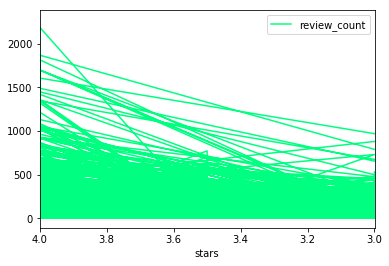

In [75]:
from IPython.display import display 

plots = ModelData.toPandas()
plots.plot(x='stars', y ='review_count',colormap='winter_r')
plt.show()

In [100]:
#from mpl_toolkits.mplot3d import Axes3D
#fig =plt.figure()
#ax=fig.add_subplot(|||, project='2D')
#ax.scatter(data_array_longitude, data_array_latitude, c='r',marker='o')
#plt.show()

In [120]:
#from numpy import array
#from pyspark.mllib.regression import LabeledPoint
#from pyspark.mllib.tree import DecisionTree

#data = [
 #    LabeledPoint(0.0, [0.0]),
#   LabeledPoint(1.0, [1.0]),
#     LabeledPoint(1.0, [2.0]),
#     LabeledPoint(1.0, [3.0])
# ]
#model = DecisionTree.trainClassifier(sc.parallelize(data), 2, {})
#print(model)

In [121]:
#temp.collect()

In [122]:
#data

In [119]:
#from numpy import array
#from pyspark.mllib.regression import LabeledPoint
#from pyspark.mllib.tree import DecisionTree

#data=sc.parallelize(temp.collect())

#model = DecisionTree.trainClassifier(temp.collect(), 4, {})
#print(model)
#data

In [128]:
standardizer = StandardScaler()
model = standardizer.fit(features)
features_transform = model.transform(features)

In [118]:
#kstest = Statistics.kolmogorovSmirnovTest
#data = temp
#ksmodel = kstest(data, "norm")
#print(round(ksmodel.pValue, 3))

#print(round(ksmodel.statistic, 3))

#ksmodel.nullHypothesis


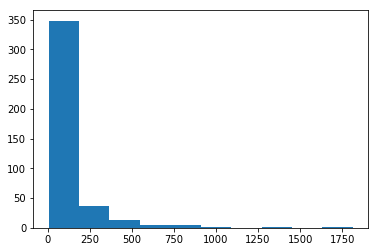

In [79]:
plt.hist(data_array_reviewCount)
plt.show()

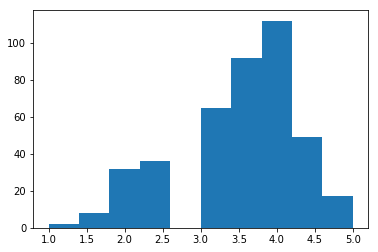

In [71]:
plt.hist(data_array_stars)
plt.show()

In [129]:
features_transform.take(5)

[DenseVector([-124.455, 25.5587, 1.5488]),
 DenseVector([-124.6159, 25.5705, 0.0168]),
 DenseVector([-124.6038, 25.5586, 0.0783]),
 DenseVector([-124.6156, 25.5706, 0.0224]),
 DenseVector([-124.4512, 25.6808, 1.286])]

In [130]:
labels = ModelData.map(lambda row: row[0])
labels.take(5)

[4.0, 2.5, 2.5, 2.0, 3.5]

In [134]:
transformedData = labels.zip(features_transform)
transformedData.take(5)


[(4.0, DenseVector([-124.455, 25.5587, 1.5488])),
 (2.5, DenseVector([-124.6159, 25.5705, 0.0168])),
 (2.5, DenseVector([-124.6038, 25.5586, 0.0783])),
 (2.0, DenseVector([-124.6156, 25.5706, 0.0224])),
 (3.5, DenseVector([-124.4512, 25.6808, 1.286]))]

In [136]:
#data= sc.parallelize(transformedData.take())

In [137]:
#trainingData, testingData = transformedData.randomSplit([.8,.2],seed=10)
splits =temp.randomSplit([.8,.2],seed=10)

In [144]:
trainingData1 = splits[0]
testingData1=splits[1]
trainingData1

PythonRDD[343] at RDD at PythonRDD.scala:43

In [35]:
trainingData.take(5)

[(4.0, DenseVector([-124.455, 25.5587, 1.5488])),
 (2.0, DenseVector([-124.6156, 25.5706, 0.0224])),
 (3.5, DenseVector([-124.3348, 25.4369, 0.1566])),
 (4.5, DenseVector([-124.4534, 25.5416, 0.6542])),
 (5.0, DenseVector([-124.4317, 25.5359, 0.0168]))]

In [140]:
from pyspark.mllib.regression import LinearRegressionWithSGD


In [141]:
linearModel = LinearRegressionWithSGD.train(trainingData1,10,.2)

In [142]:
linearModel.weights

DenseVector([9.4352, -2.8232, -2.8403])

In [143]:
linearModel.predict([7.3023, -2.1849, -2.1273])

1.3549011853998236e+35